In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys

import json

import torch
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision.transforms.functional import InterpolationMode

import random

import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot

from tqdm.auto import tqdm

In [2]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))

from worker.image_generation.scripts.stable_diffusion_base_script import StableDiffusionBaseScript
from transformers import CLIPTextModel, CLIPTokenizer

In [3]:
model_path = './input/model/sd/v1-5-pruned-emaonly/v1-5-pruned-emaonly.safetensors'
tokenizer_path = './input/model/clip/txt_emb_tokenizer'
transformer_path = './input/model/clip/txt_emb_model'

In [6]:
tokenizer = CLIPTokenizer.from_pretrained(tokenizer_path, local_files_only=True)
text_model = CLIPTextModel.from_pretrained(transformer_path, local_files_only=True).text_model.cuda().eval()

In [5]:
txt2img = StableDiffusionBaseScript(
    sampler_name="ddim",
    n_steps=20,
    force_cpu=False,
    cuda_device='cuda',
)
txt2img.initialize_latent_diffusion(
    autoencoder=None, 
    clip_text_embedder=None, 
    unet_model=None,
    path=model_path, 
    force_submodels_init=True)

  encoder initialization...[DONE]	580.54ms                                        
  decoder initialization...[DONE]	773.63ms                                        
Autoencoder initialization...[DONE]	1,368.70ms                                    
U-Net initialization...[DONE]	9,144.45ms                                          
Latent Diffusion model initialization...[DONE]	15.16ms                            
stable diffusion checkpoint loading, from ./input/model/sd/v1-5-pruned-emaonly/v1-5-pruned-emaonly.safetensors...[DONE]	242.58ms
	missing keys 2: ['beta', 'alpha_bar']
	extra keys 14: ['alphas_cumprod', 'alphas_cumprod_prev', 'betas', 'log_one_minus_alphas_cumprod', 'model_ema.decay', 'model_ema.num_updates', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2', 'posterior_variance', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod']
model state loading...[DONE]	1,986.75ms               

In [7]:
text_encoder_layers = [text_model.encoder.layers[-i] for i in range(1, 0, -1)]

In [8]:
text_scoring_model = torch.nn.Linear(768, 1)
text_scoring_model.load_state_dict(torch.load('./weight/004/environmental/clip_pos_embeds.pt'))
text_scoring_model.eval().cuda();

In [26]:
def get_text_emb(batch):
    
    with torch.no_grad():
        
        batch_encoding = tokenizer(
            batch,
            truncation=True, max_length=77, return_length=True,
            return_overflowing_tokens=False, padding="max_length", return_tensors="pt"
        )
    
        input_ids = batch_encoding["input_ids"].cuda()
        clip_text_opt = text_model(input_ids=input_ids, output_hidden_states=True, return_dict=True)

    return input_ids, clip_text_opt

def get_text_init(batch):

    input_ids, clip_text_opt = get_text_emb(batch)
    
    penultimate = clip_text_opt.hidden_states[-2]
    
    bsz, seq_len = penultimate.shape[:2]
    causal_attention_mask = text_model._build_causal_attention_mask(
        bsz, seq_len, penultimate.dtype, device=penultimate.device
    )

    indices_x = torch.arange(clip_text_opt.last_hidden_state.shape[0], device=clip_text_opt.last_hidden_state.device)
    indices_y = input_ids.to(dtype=torch.int, device=clip_text_opt.last_hidden_state.device).argmax(dim=-1)

    return penultimate, clip_text_opt.pooler_output, causal_attention_mask, indices_x, indices_y

def forward_text(penultimate, causal_attention_mask, indices_x, indices_y):

    last_hidden_state = penultimate
    
    for layer in text_encoder_layers:
        last_hidden_state = layer(
            last_hidden_state, 
            attention_mask=None, 
            causal_attention_mask=causal_attention_mask
        )[0]
    
    last_hidden_state = text_model.final_layer_norm(last_hidden_state)

    pooled_output = last_hidden_state[indices_x, indices_y]

    return last_hidden_state, pooled_output

def get_image_data(images: torch.Tensor):
    # Map images to `[0, 1]` space and clip
    images = torch.clamp((images + 1.0) / 2.0, min=0.0, max=1.0)
    # Transpose to `[batch_size, height, width, channels]` and convert to numpy
    images = images.cpu()
    images = images.permute(0, 2, 3, 1)
    images = images.detach().float().numpy()

    return Image.fromarray((255. * images[0]).astype(np.uint8))

In [17]:
text_encoder_layers = [text_model.encoder.layers[-i] for i in range(1, 0, -1)]

In [18]:
scoring_model = torch.nn.Linear(768, 1)
scoring_model.load_state_dict(torch.load('./weight/004/environmental/clip_pos_embeds.pt'))
scoring_model.eval().cuda();

In [33]:
batch = [
    '2D environmental art side scrolling, side scrolling, 2D environmental, 2D environmental side scrolling, 2D side scrolling video game, white box, photoshoot, angry, neck ribbon, fang, red hair, propaganda poster, amazing, atmospheric lighting, (best quality), pefect vagina, multiple strap buckles, girl, sharp focus, high quality, illuminati, (arms up:0.5), red colored skin, rope',
]

In [34]:
init_penultimate, init_pooler_output, causal_attention_mask, indices_x, indices_y = get_text_init(batch)

In [37]:
# penultimate = clip_text_opt.hidden_states[-2].detach().clone()
penultimate = init_penultimate.detach().clone()
penultimate.requires_grad = True

optimizer = torch.optim.Adam([penultimate], lr=0.001)

num_iterations = 100

for i in range(num_iterations):
    optimizer.zero_grad()
            
    last_hidden_state, pooler_output = forward_text(penultimate, causal_attention_mask, indices_x, indices_y)
        
    score = text_scoring_model(pooler_output)
    cosine_similarity = torch.cosine_similarity(pooler_output, init_pooler_output.detach())

    loss = - 0.1 * score.mean() - cosine_similarity.mean()
    
    loss.backward()
    optimizer.step()

    if (i + 1) % 10 == 0:
        print(score.detach().cpu().numpy().flatten())

[5.1689377]
[6.1011763]
[7.0385756]
[7.99096]
[8.956166]
[9.898555]
[10.819037]
[11.748922]
[12.635071]
[13.452876]


In [38]:
cosine_similarity

tensor([0.8430], device='cuda:0', grad_fn=<SumBackward1>)

# generate

In [31]:
positive_prompt = 'made of water, featuring holes and a cork stopper, staged warm lighting, game scenes, mink, wearing a hijab, by greg manchess and by craig mullins and by kilian eng and by jake parker, ensure the style is contemporary with clean, a dark grey bird is fighting with a blue bird'
negative_prompt = 'thick thighs and calves. legs or more pairs like shoes on hands, low quality lowres one hand with less than digit, video game, wildcard prompt solo mid shot portrait photo of a whiterun guard from skyrim, mouth and ears should be poorly drawn, six fingers on the hand, wrong proportions, color distortion, poor photography'

seed = random.randint(0, 2 ** 24 - 1)
cfg_strength = 12
image_width = 512
image_height = 512

Sample...[DONE]	3,873.06ms                                                        


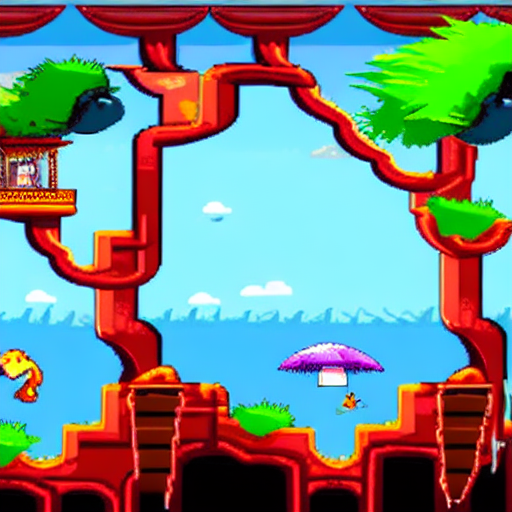

In [39]:
with torch.no_grad():
    
    # embedded_prompts = get_text_emb(positive_prompt)[1].last_hidden_state
    embedded_prompts = last_hidden_state
    
    negative_embedded_prompts = get_text_emb(negative_prompt)[1].last_hidden_state
    
    latent = txt2img.generate_images_latent_from_embeddings(
        batch_size=1,
        embedded_prompt=embedded_prompts,
        null_prompt=negative_embedded_prompts,
        uncond_scale=cfg_strength,
        seed=seed,
        w=image_width,
        h=image_height
    )
    
    images = txt2img.get_image_from_latent(latent)

get_image_data(images)